In [1]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

In [2]:
import os
import cv2
import logging
import numpy as np
import methods
import torch as th
from skimage.util import random_noise
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm
import albumentations as A

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [3]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, rotate_limit=90, scale_limit=[0,0.3], always_apply=True, p=1)
])

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
dim = (32, 32)
height, width = dim
transformed_cCry = methods.getTransformedImages("cCry", dim, transform, 200)
transformed_sCry = methods.getTransformedImages("sCry", dim, transform, 40)
transformed_uCry = methods.getTransformedImages("uCry", dim, transform, 40)
transformed_hCast = methods.getTransformedImages("hCast", dim, transform, 200)
transformed_nhCast = methods.getTransformedImages("nhCast", dim, transform, 200)
transformed_nsEC = methods.getTransformedImages("nsEC", dim, transform, 20)
transformed_sEC = methods.getTransformedImages("sEC", dim, transform, 20)
transformed_WBC = methods.getTransformedImages("WBC", dim, transform, 10)
transformed_RBC = methods.getTransformedImages("RBC", dim, transform, 10)
transformed_BC = methods.getTransformedImages("BC", dim, transform, 4)

transformed_all = np.concatenate((transformed_cCry, transformed_sCry, transformed_uCry, transformed_hCast, 
                                 transformed_nhCast, transformed_nsEC, transformed_sEC, transformed_WBC,
                                 transformed_RBC, transformed_BC))

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers_loop = [testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC]
X_outliers_loop = [testImages_Artifact, testImages_Dirt, testImages_LD]

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

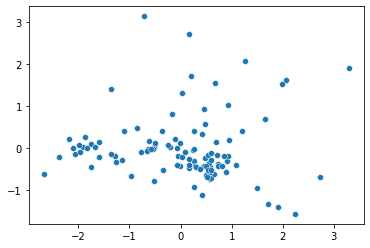

some


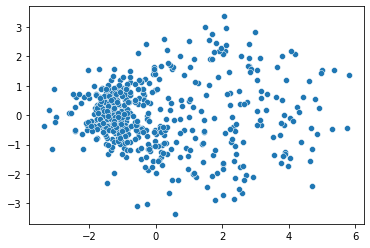

some


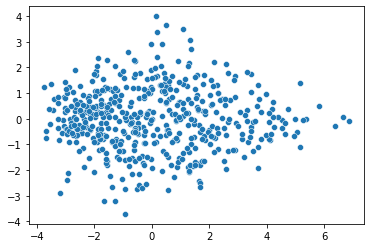

some


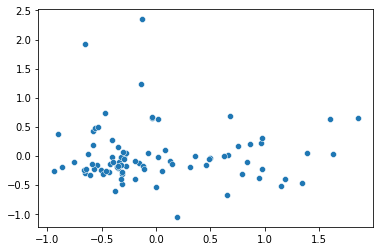

some


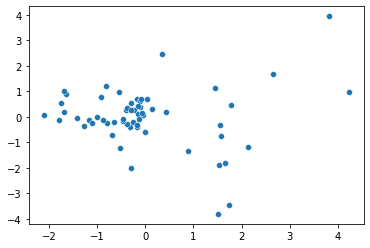

some


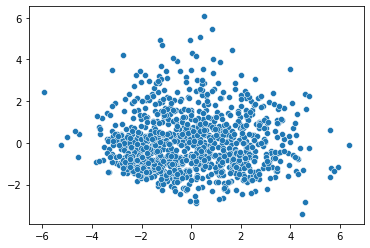

some


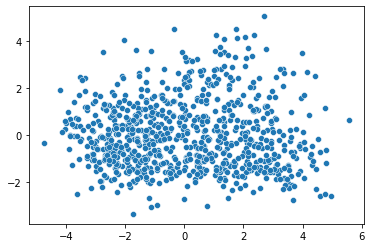

some


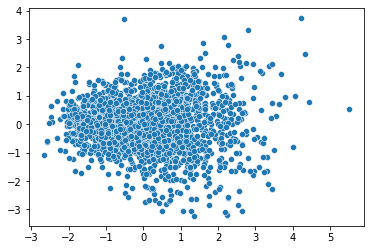

some


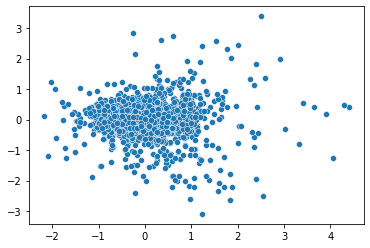

some


In [12]:
pca = PCA(n_components = 2)

for inlier in X_inliers_loop:
    X_transform = pca.fit_transform(inlier.reshape(-1, 32*32))
    a = sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])
    plt.show(a)
    print("some")